## **Entrenamiento de YOLOv3 para la detección y reconocimiento de billetes peruanos**

Entrenaremos nuestro modelo para detectar billetes de 10, 20, 50 y 100 soles.

In [ ]:
# Verficando que la GPU este habilitada y disponible
!nvidia-smi

Tue Mar  2 19:35:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Conexión a Google Drive**
Vincularemos este notebook de Google Colab con nuestro almacenamiento en Google Drive para importar nuestro dataset y realizar Backups de los pesos generados por el entrenamiento.

In [ ]:
# Limpiamos y desmontamos Google Drive vinculado a este notebook debido a cualquier inicialización previa
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
drive.mount('/content/drive')

# Creamos un enlace simbolico llamado "MyGDrive" para acceder más fácilmente a la siguiente ruta a la cual accederemos constantemente: /content/drive/My\ Drive/
!ln -s /content/drive/My\ Drive/ /MyGDrive
!ls /MyGDrive

## **Importando el Dataset de billetes desde Google Drive**
Importamos nuestro Dataset de billetes existente en Google Drive y lo transferimos a esta conexión en Google Colab.

In [ ]:
# Accedemos a nuestro almacenamiento en Drive para verificar que se tenga acceso a los archivos necesarios (el dataset y la carpeta para el entrenamiento)
!ls /content/drive/My\ Drive/Yolov3

 backup			 images.zip   obj.data		  yolov3_ygb.cfg
 generate_train.py	 img	      obj.names
'images(antiguas).zip'	 imgTest      yolov3_custom.cfg


In [ ]:
#Copiamos el dataset comprimido (images.zip) a la raíz de nuextra máquina virtual existente en la nube de Google Colab
!cp /content/drive/My\ Drive/Yolov3/images.zip /content/

## **1) Clonando la Darknet**

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14730 (delta 2), reused 7 (delta 2), pack-reused 14722
Receiving objects: 100% (14730/14730), 13.25 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (10016/10016), done.


## **2) Compilando la Darknet usando la GPU de Nvidia**

In [ ]:
%cd darknet/

/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

## **3) Configurando la Darknet para el entrenamiento de YOLO V3**

In [ ]:
# Descargaremos los archivos de configuración (.cfg) de nuestro directorio en Google Drive
%cd /content/darknet/

/content/darknet


In [ ]:
!cp /MyGDrive/Yolov3/yolov3_ygb.cfg cfg/yolov3_ygb.cfg 
!cp /MyGDrive/Yolov3/yolov3_custom.cfg cfg/yolov3_custom.cfg 

In [ ]:
!ls

3rdparty	darknet			include		       results
backup		DarknetConfig.cmake.in	json_mjpeg_streams.sh  scripts
build		darknet_images.py	LICENSE		       src
build.ps1	darknet.py		Makefile	       vcpkg.json
build.sh	darknet_video.py	net_cam_v3.sh	       video_yolov3.sh
cfg		data			net_cam_v4.sh	       video_yolov4.sh
cmake		image_yolov3.sh		obj
CMakeLists.txt	image_yolov4.sh		README.md


In [ ]:
# Copiamos los archivos de data para el entrenamiento a la carpeta de Darknet en la ruta con la configuración necesaria para el entranamiento
!cp /content/drive/My\ Drive/Yolov3/obj.names /content/darknet/data/ 
!cp /content/drive/My\ Drive/Yolov3/obj.data /content/darknet/data/ 

In [ ]:
# Descomprimimos nuestro dataset con las imágenes y etiquetas de billetes para generar el archivo de entrenamiento
!unzip ../images.zip -d /content/darknet/data/colab/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/darknet/data/colab/20210119_213444_mfnr_copy_600x450.txt  
  inflating: /content/darknet/data/colab/20210119_213511_mfnr_copy_600x450.jpg  
  inflating: /content/darknet/data/colab/20210119_213511_mfnr_copy_600x450.txt  
  inflating: /content/darknet/data/colab/20210119_213518_mfnr_copy_600x450.jpg  
  inflating: /content/darknet/data/colab/20210119_213518_mfnr_copy_600x450.txt  
  inflating: /content/darknet/data/colab/20210119_213524_mfnr_copy_600x450.jpg  
  inflating: /content/darknet/data/colab/20210119_213524_mfnr_copy_600x450.txt  
  inflating: /content/darknet/data/colab/20210119_213527_mfnr_copy_600x450.jpg  
  inflating: /content/darknet/data/colab/20210119_213527_mfnr_copy_600x450.txt  
  inflating: /content/darknet/data/colab/20210119_213540_mfnr_copy_600x800.jpg  
  inflating: /content/darknet/data/colab/20210119_213540_mfnr_copy_600x800.txt  
  inflating: /content/darknet/data/colab/2021011

## **4) Generando el archivo de entrenamiento (train.txt)**

In [ ]:
!cp /content/drive/My\ Drive/Yolov3/generate_train.py ../

In [ ]:
# Ejecutamos el script para separar nuestro dataset en imágenes para el entrenamiento (train) y las pruebas (test)
%cd /content/
!python generate_train.py

/content
['/content/darknet/data/colab/20210119_205117_mfnr_copy_600x450.jpg', '/content/darknet/data/colab/20210119_203918_mfnr_copy_600x450.jpg', '/content/darknet/data/colab/8372226168729831.jpg', '/content/darknet/data/colab/7083912992065369.jpg', '/content/darknet/data/colab/20210209_202916_mfnr_copy_600x800.jpg', '/content/darknet/data/colab/IMG_20210119_174744_2_copy_420x420.jpg', '/content/darknet/data/colab/20210119_210851_mfnr_copy_600x450.jpg', '/content/darknet/data/colab/20210117_192651_copy_460x816.jpg', '/content/darknet/data/colab/20210209_210024_mfnr_copy_600x800.jpg', '/content/darknet/data/colab/8019635785859799.jpg', '/content/darknet/data/colab/IMG_20210119_173742_1_copy_684x1485.jpg', '/content/darknet/data/colab/8383534116596749.jpg', '/content/darknet/data/colab/20210209_204747_mfnr_copy_600x800.jpg', '/content/darknet/data/colab/20210119_195317_mfnr_copy_600x800.jpg', '/content/darknet/data/colab/IMG_20210119_174257_3_copy_684x1485.jpg', '/content/darknet/data/

In [ ]:
!pwd

/content


## 5) Descargamos pesos pre entrenados para capas de convolución


In [ ]:
# Descargar pesos de las capas convolucionales preentrenadas de Darknet-53
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2021-02-14 16:24:16--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2021-02-14 16:24:16--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  45.3MB/s    in 3.8s    

2021-02-14 16:24:20 (41.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



##6) Entrenamiento de nuetros detector de billetes

In [ ]:
# Definimos una función para mostrar imágenes dentro de las celdas (al momento de probar nuestro modelo después del entrenamiento)
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(9, 5)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
# Iniciamos el entrenamiento de Yolov3
%cd /content/darknet
!./darknet detector train data/obj.data cfg/yolov3_ygb.cfg /content/darknet53.conv.74 -dont_show

Se han truncado las últimas 5000 líneas del flujo de salida.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 123882, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.870139), count: 4, class_loss = 0.100278, iou_loss = 0.073994, total_loss = 0.174272 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 123886, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.851858), count: 4, class_loss = 0.011842, iou_loss = 0.093892, total_loss = 0.105

In [ ]:
# Cada 100 steps (pasos) se guarda una versión de avance del archivo de pesos generado sobre nuestro almacenamiento en Google Colab con nombre (yolov3_ygb_last.weights)

Para que nuestro modelo sea 'preciso', la pérdida (avg loss) debería estar por debajo de 2. Para ello sería necesario llegar a una cantidad de steps (pasos) mayor a 2000.

NOTA 1: Como el entrenamiento puede tomar varias horas dependiendo de cuántas iteraciones haya elegido en el archivo .cfg. Puede darse el caso de que Google Colab Cloud Service detenga el entorno de ejecución de máquinas virtuales si este está inactivo durante demasiado tiempo (30-90 minutos).

Para evitar esto, podríamos ejecutar un script en la consola del navegador para simular clics en la ventana, cada cierto tiempo.

Podemos utilizar el siguiente script (código en Javascript):
```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
Este script simula clics cada 60 segundos.


NOTA 2: Es necesario configurar nuestro equipo para que no se suspenda o hiberne.

####  **6.1) Continuar el entrenamiento desde un archivo backup de pesos de Yolo**

Si por alguna razón se genera un error el entorno de ejecución de Google Colab se queda inactivo durante el entrenamiento, es posible continuar el entrenamiento desde un punto de restauración. Cada 100 iteraciones se guarda un archivo de pesos llamado yolov3_custom_last.weights en la carpeta MyGDrive/yolov3/backup/ 

Para hacerlo, simplemente ejecutamos el siguiente comando pero con la ubicación del archivo de pesos generado de respaldo.

In [ ]:
%cd /content/darknet
!./darknet detector train data/obj.data cfg/yolov3_ygb.cfg /MyGDrive/Yolov3/backup/yolov3_ygb_last.weights -dont_show

Se han truncado las últimas 5000 líneas del flujo de salida.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.915246), count: 4, class_loss = 0.000052, iou_loss = 0.029193, total_loss = 0.029245 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 204249, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.956234), count: 4, class_loss = 0.000001, iou_loss = 0.012338, total_loss = 0.012339 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00

In [ ]:
!ls

backup		   images.zip  obj.data   yolov3_custom.cfg
generate_train.py  img	       obj.names  yolov3_ygb.cfg


## 7) Ejecutando nuestro modelo de detección de billetes

In [ ]:
# Necesitamos configurar nuestro archivo custom.cfg para el modo de detección  
%cd /content/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
# Definimos una función para mostrar imágenes dentro de las celdas (al momento de probar nuestro modelo después del entrenamiento)
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)  # leyendo la imagen (mediante funcion de opencv)
  print("#######################################################")
  print(type(image))
  height, width = image.shape[:2]   # obteniendo el tamaño de la imagen (por ejemplo, 800 x 600)
  print(height, width)
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  print(fig)  # Figure(432x288)
  fig.set_size_inches(9, 5) # Figure(648x360)
  print(fig)
  plt.axis("on")  # ejes numerados a escala
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

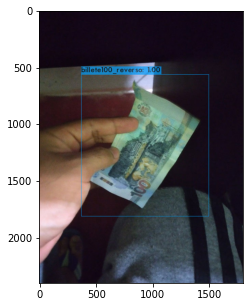

In [ ]:
# Ejecutamos nuestro detector de billetes 
# cargamos una imagen o imágenes a nuestro almacenamiento en Google Drive para probar el modelo entrenado 
# La marca umbral de detección (treshold) establece la precisión que debe tener la detección para mostrar que existe un billete o billetes dentro de la imagen
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /MyGDrive/Yolov3/backup/yolov3_ygb_last.weights /MyGDrive/Yolov3/imgTest/7billete100Reverso/20210228_215934_mfnr_copy_600x800.jpg -thresh 0.85
imShow('predictions.jpg')

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

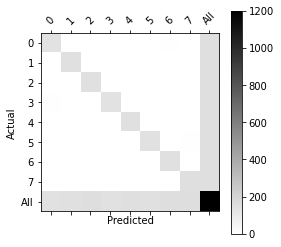

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


labels = ['0','1','2','3','4','5','6','7']
labels = ['billete10_cara','billete10_reverso','billete20_cara',
          'billete20_reverso','billete50_cara','billete50_reverso',
          'billete100_cara','billete100_reverso']

fileHandler = open('labelsReales.txt', 'r')
listaLineas = fileHandler.readlines()
listaLabelsReales = listaLineas[0].strip().split(' ')
fileHandler.close()

i = 0
for i in range(len(listaLabelsReales)):
  listaLabelsReales[i] = labels.index(listaLabelsReales[i])

print(listaLabelsReales)

fileHandler = open('predicciones.txt', 'r')
listaLineas = fileHandler.readlines()
listaPredicciones = listaLineas[0].strip().split(' ')
fileHandler.close()

i = 0
for i in range(len(listaPredicciones)):
  listaPredicciones[i] = labels.index(listaPredicciones[i])

#MATRIZ DE CONFUSIÓN
print("Predicción con etiquetas con las imagenes  :  ")
print("")
y_actu=list()
y_pred=list()

y_actu = listaLabelsReales
y_pred = listaPredicciones

y_actu = pd.Series(y_actu, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')


df_confusion = pd.crosstab(y_actu, y_pred,margins=True)

print(df_confusion)
print("")
plot_confusion_matrix(df_confusion)

df = pd.DataFrame(0,index='0 1 2 3 4 5 6 7 8'.split(),columns='TP_Rate FP_Rate'.split())

In [21]:
#RATIOS
cnf_matrix = confusion_matrix(y_actu, y_pred)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)
ACC = (TP+TN)/(TP+FP+FN+TN)
ACCT=(TP.sum() +TN.sum())/(TP.sum()+FP.sum()+FN.sum()+TN.sum())  

print("")
#print(TPR)
#print(FPR)
df = pd.DataFrame({'TP_Rate':TPR,'FP_Rate':FPR,'ACCURACY':ACC})
print("Ratio de precisión:",ACCT)

print()

df

[[138   0   4   0   3   0   5   0]
 [  0 146   0   0   0   4   0   0]
 [  0   0 148   0   1   0   1   0]
 [  5   0   2 140   0   0   3   0]
 [  1   0   2   0 147   0   0   0]
 [  0   0   0   1   0 144   0   5]
 [  0   0   0   0   1   0 149   0]
 [  0   0   0   0   0   0   0 150]]

Ratio de precisión: 0.9920833333333333



TP_Rate   FP_Rate  ACCURACY
0  0.920000  0.005714  0.985000
1  0.973333  0.000000  0.996667
2  0.986667  0.007619  0.991667
3  0.933333  0.000952  0.990833
4  0.980000  0.004762  0.993333
5  0.960000  0.003810  0.991667
6  0.993333  0.008571  0.991667
7  1.000000  0.004762  0.995833